In [2]:
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from Slide_Window_and_Graph import create_graph_list_from_df
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
# from GNN_LSTKAN_Model import GNN_plus_LSTKAN
# from GNN_LSTKAN_Attention import GNN_LSTKAN_with_Attention, GNNEncoder
from loss_function.GNN_LSTM_with_Attention_V2 import GNN_LSTKAN_with_Attention_v2, GNNEncoder
from kan_improved import KAN
from loss_function.custom_lossess_v4 import jerk_smoothness_loss_v2, velocity_heading_consistency_loss_v2 
# from loss_function.custom_lossess_v2 import trajectory_dynamics_loss, physics_violation_loss, heading_change_loss
# from loss_function.custom_lossess_v3 import heading_change_loss, jerk_loss
from loss_function.learnable_loss import LearnableLossWeighter

In [3]:
def split_data_with_gap(data: pd.DataFrame, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, gap_ratio=0.05):
    """
    策略一：”间隔式“时序划分。
    在训练集、验证集和测试集之间插入间隔数据并丢弃，以减少时间上的相关性。

    参数:
        data (pd.DataFrame): 完整的、按时间排序的数据集。
        train_ratio (float): 训练集所占比例。
        val_ratio (float): 验证集所占比例。
        test_ratio (float): 测试集所占比例。
        gap_ratio (float): 训练集与验证集、验证集与测试集之间的间隔比例。

    返回:
        tuple: (train_df, val_df, test_df)
    """
    # 确保比例总和不超过1
    total_ratio = train_ratio + val_ratio + test_ratio + gap_ratio * 2
    if total_ratio > 1.0:
        # 按比例缩放，确保总和为1
        scale_factor = 1.0 / total_ratio
        train_ratio *= scale_factor
        val_ratio *= scale_factor
        test_ratio *= scale_factor
        gap_ratio *= scale_factor
        print(f"警告：比例总和大于1，已自动缩放。")

    data_size = len(data)

    # 计算分割点
    train_end_idx = int(train_ratio * data_size)
    
    gap1_start_idx = train_end_idx
    gap1_end_idx = gap1_start_idx + int(gap_ratio * data_size)

    val_start_idx = gap1_end_idx
    val_end_idx = val_start_idx + int(val_ratio * data_size)

    gap2_start_idx = val_end_idx
    gap2_end_idx = gap2_start_idx + int(gap_ratio * data_size)

    test_start_idx = gap2_end_idx

    # 使用 .iloc 分割 DataFrame
    train_df = data.iloc[:train_end_idx]
    val_df = data.iloc[val_start_idx:val_end_idx]
    test_df = data.iloc[test_start_idx:]
    
    print("--- 已使用“间隔式”时序划分 ---")
    print(f"训练集: {len(train_df)} 行 ({(len(train_df)/data_size)*100:.1f}%)")
    print(f"丢弃的间隔1: {len(data.iloc[gap1_start_idx:gap1_end_idx])} 行")
    print(f"验证集: {len(val_df)} 行 ({(len(val_df)/data_size)*100:.1f}%)")
    print(f"丢弃的间隔2: {len(data.iloc[gap2_start_idx:gap2_end_idx])} 行")
    print(f"测试集: {len(test_df)} 行 ({(len(test_df)/data_size)*100:.1f}%)")
    
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [ ]:
"""数据流:原始数据 -> HeteroData列表 -> PyG DataLoader -> HeteroDataBatch对象 -> 模型"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ======================0.15_Speed_OB.csv专用=================================
# direct = "Datasets/"
filesname = "Garage.csv"
# data = pd.read_csv(direct + filesname)
# print(f"成功加载数据集，总行数: {len(data)}")

# print("\n--- 步驟 2: 數據清洗 ---")

# 檢查哪些列的所有值都為 0
# (data == 0) 會生成一個布爾值的 DataFrame
# .all(axis=0) 會檢查每一列是否所有值都為 True
# all_zero_columns = data.columns[(data == 0).all()]

# if not all_zero_columns.empty:
#     print(f"檢測到 {len(all_zero_columns)} 個全為零的'無信息'列，將其移除...")
#     print("被移除的列:", list(all_zero_columns))
    
#     # 使用 .drop() 方法移除這些列
#     data = data.drop(columns=all_zero_columns)
    
#     print(f"清洗完成。數據集新維度: {data.shape}")
# else:
#     print("數據集中未發現全為零的列，無需清洗。")
    
# # 2. 定义分割比例
# train_ratio = 0.8
# val_ratio = 0.1
# # # 剩下的 10% 将作为测试集

# # # 3. 计算分割点索引 (按时间顺序)
# data_size = len(data)
# train_end_idx = int(train_ratio * data_size)
# val_end_idx = train_end_idx + int(val_ratio * data_size)

# # # # 4. 使用 .iloc 分割 DataFrame
# train_data = data.iloc[:train_end_idx]
# val_data = data.iloc[train_end_idx:val_end_idx]
# test_data = data.iloc[val_end_idx:]
# train_data, val_data, test_data = split_data_with_gap(data)
#======================0.15_Speed_OB.csv专用=================================




train_data = pd.read_csv(
    r'Datasets/x_train.csv')
val_data = pd.read_csv(
    r'Datasets/x_val.csv')
test_data = pd.read_csv(
    r'Datasets/x_test.csv')

print("\nData loaded successfully!")
print(f"Training data shape:   {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Testing data shape:    {test_data.shape}")
# 分离WiFi和IMU特征
column_names = train_data.drop(['timestamp','x_coord', 'y_coord'], axis=1).columns.tolist()
# column_names = train_data.drop(['z','x_coord', 'y_coord'], axis=1).columns.tolist()
coord_cols = ['x_coord', 'y_coord']
# wifi_features = [col for col in column_names if any(sensor in col for sensor in ["rot", "RSSI"])] 
wifi_features = [col for col in column_names if any(sensor in col for sensor in ["RSSI","distance"])] 
# imu_features = [col for col in column_names if any(sensor in col for sensor in ["accelerometer", "gyroscope"])] 
imu_features = [col for col in column_names if any(sensor in col for sensor in ["accelerometer", "gyroscope","magnetometer"])] 
print(f"\nIdentified {len(wifi_features)} WiFi features and {len(imu_features)} IMU features.")




Data loaded successfully!
Training data shape:   (2688, 24)
Validation data shape: (2399, 24)
Testing data shape:    (2664, 24)

Identified 12 WiFi features and 9 IMU features.


In [5]:
# 3. 在DataFrame上进行标准化
# 创建 Scaler
scaler_wifi = StandardScaler().fit(train_data[wifi_features])
scaler_imu = StandardScaler().fit(train_data[imu_features])

coords=train_data[['x_coord','y_coord']]
scaler = StandardScaler()
scaler.fit(coords)

# 创建数据的副本以避免SettingWithCopyWarning
train_df_scaled = train_data.copy()
val_df_scaled = val_data.copy()
test_df_scaled = test_data.copy()

# 对训练、验证、测试集应用标准化
for df in [train_df_scaled, val_df_scaled, test_df_scaled]:
    df[wifi_features] = scaler_wifi.transform(df[wifi_features])
    df[imu_features] = scaler_imu.transform(df[imu_features])
    df[coord_cols] = scaler.transform(df[coord_cols])
print("数据已在DataFrame上完成标准化，timestamp信息被保留。")

#======================================================================================================================================

# # --- 绘制热力图 ---
# plt.figure(figsize=(12, 8)) # 设置图表大小

# # 使用 seaborn 绘制热力图
# # cmap='plasma' 或 'viridis' 是常用的紫色到黄色渐变配色
# # annot=False 表示不在热力图上显示每个单元格的数值，以避免重叠
# # cbar=True 显示颜色条
# sns.heatmap(
#     train_wifi_scaled,
#     cmap='plasma', # <<<--- 这里修改为 'plasma' 来实现紫色到黄色的配色
#     annot=False,   # 保持为 False，避免数值重叠
#     fmt=".2f",
#     cbar=True
# )

# plt.title('train_wifi_scaled heatmap', fontsize=16) # 设置图表标题
# plt.xlabel('target dimension features', fontsize=14) # <<<--- 修正拼写：dimemsion -> dimension
# plt.ylabel('flattened samples', fontsize=14) # <<<--- 修正拼写：flatterd -> flattened

# plt.tight_layout() # 自动调整图表布局，确保所有元素都可见

# # 保存图表到文件
# output_filename = 'train_wifi_scaled_heatmap.png'
# plt.savefig(output_filename)
# print(f"热力图已保存为 '{output_filename}'")

# #显示图表（在支持图形界面的环境中运行会弹出窗口显示图像）
# plt.show()

数据已在DataFrame上完成标准化，timestamp信息被保留。


In [6]:
# 定义窗口参数
windows_size = 30 
future_steps = 3

future_radius = 5
past_radius = 15

print("正在从DataFrame创建异构图数据列表...")

train_data_list = create_graph_list_from_df(
    df=train_df_scaled, 
    wifi_cols=wifi_features, 
    imu_cols=imu_features, 
    windows_size=windows_size, 
    future_steps=future_steps, 
    device='cpu',
    future_radius=future_radius,
    past_radius=past_radius
)

val_data_list = create_graph_list_from_df(
    df=val_df_scaled, 
    wifi_cols=wifi_features, 
    imu_cols=imu_features, 
    windows_size=windows_size, 
    future_steps=future_steps, 
    device='cpu',
    future_radius=future_radius,
    past_radius=past_radius
)

test_data_list = create_graph_list_from_df(
    df=test_df_scaled, 
    wifi_cols=wifi_features, 
    imu_cols=imu_features, 
    windows_size=windows_size, 
    future_steps=future_steps, 
    device='cpu',
    future_radius=future_radius,
    past_radius=past_radius
)

print("图数据列表创建完毕。")
# train_data_list 就是最终可以直接喂给DataLoader的数据了



正在从DataFrame创建异构图数据列表...
图数据列表创建完毕。


In [7]:
# --- [修改] 使用 PyG 的 DataLoader ---
batch_size = 128 
train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=False) 
val_loader = DataLoader(val_data_list, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data_list, batch_size=batch_size, shuffle=False)
print("数据加载器创建完毕。")


数据加载器创建完毕。


正在實例化 GNN+LSTKAN 端到端模型...
端到端模型实例化完成
优化器与ReduceLROnPlateau调度器定义完毕，初始最大学习率: 0.0003

--- 開始模型訓練 (帶航向變化損失) ---
當前損失權重: 1.0


Epoch 309/500 [Anneal Factor: 1.00]:  62%|██████▏   | 309/500 [10:35<06:32,  2.06s/epoch, BestVal=0.0057, LR=0.000005, Patience=30/30, TrainLoss=0.0023, ValLoss=0.0058]


Early stopping at epoch 309

Loading best model for testing...


Testing: 100%|██████████| 21/21 [00:00<00:00, 33.44it/s]


Test Loss: 0.0031
Test results saved to 'results/Gkan_Garage.csv'

--- 模型评估结果 ---
X轴均方误差 (MSE X): 0.1643 (米^2)
Y轴均方误差 (MSE Y): 7.7094 (米^2)
总均方误差 (Total MSE): 3.9369 (米^2)
--------------------
总均方根误差 (RMSE): 1.9842 (米)
平均位移误差 (ADE/FDE): 2.3945 (米)
--------------------


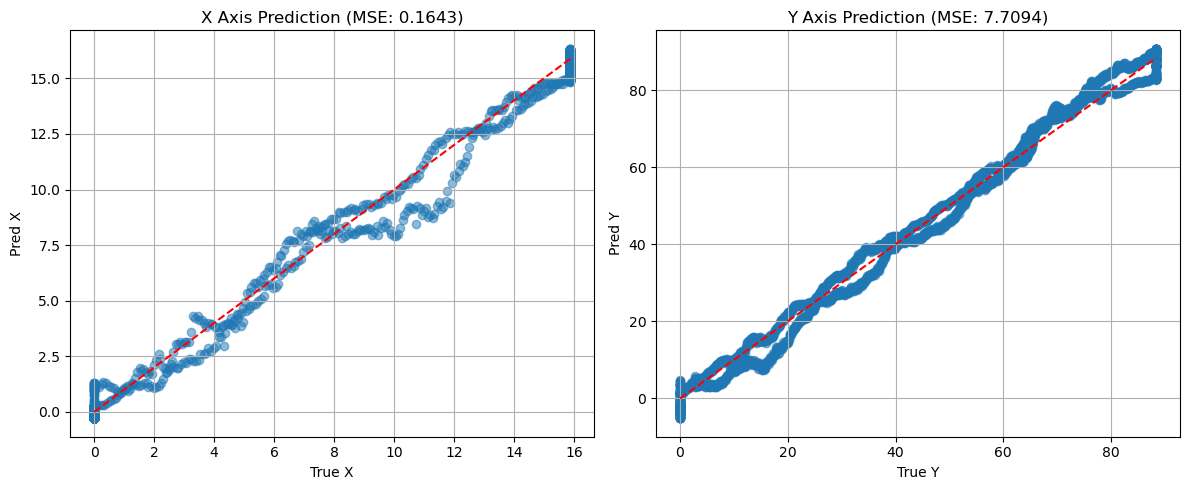


--- Generating visualization plots... ---
Plotting training and validation loss curve...
✅ Loss curve plot saved as 'Picture/loss_curve_gnn_kan_en.png'


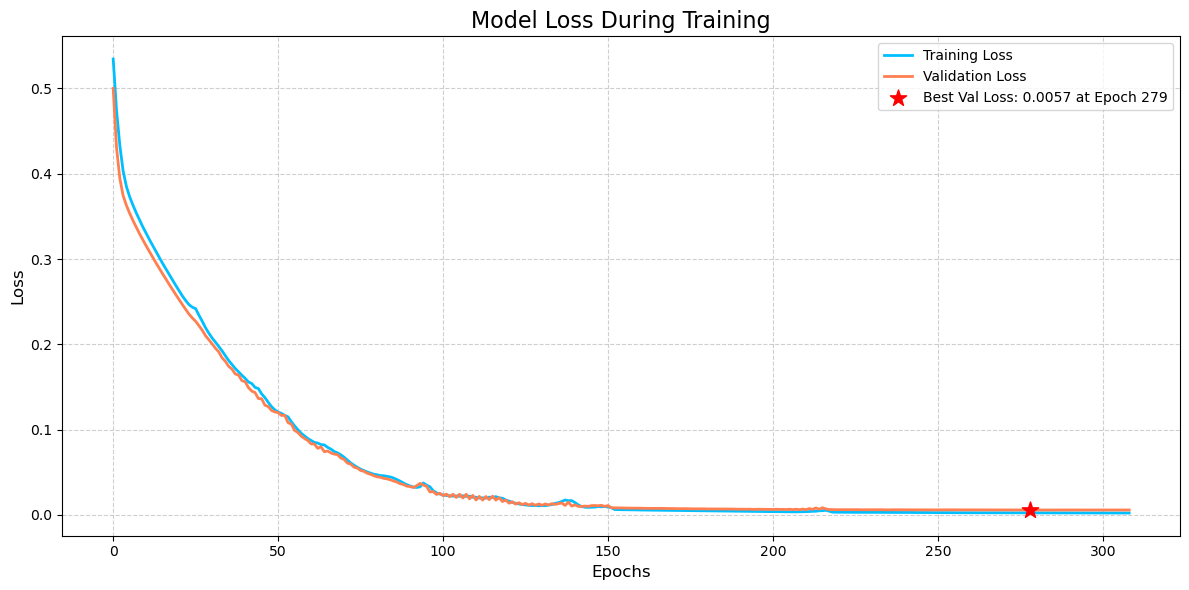

Plotting predicted vs. true path...
✅ Path comparison plot saved as 'Picture/path_comparison_gnn_kan_en.png'


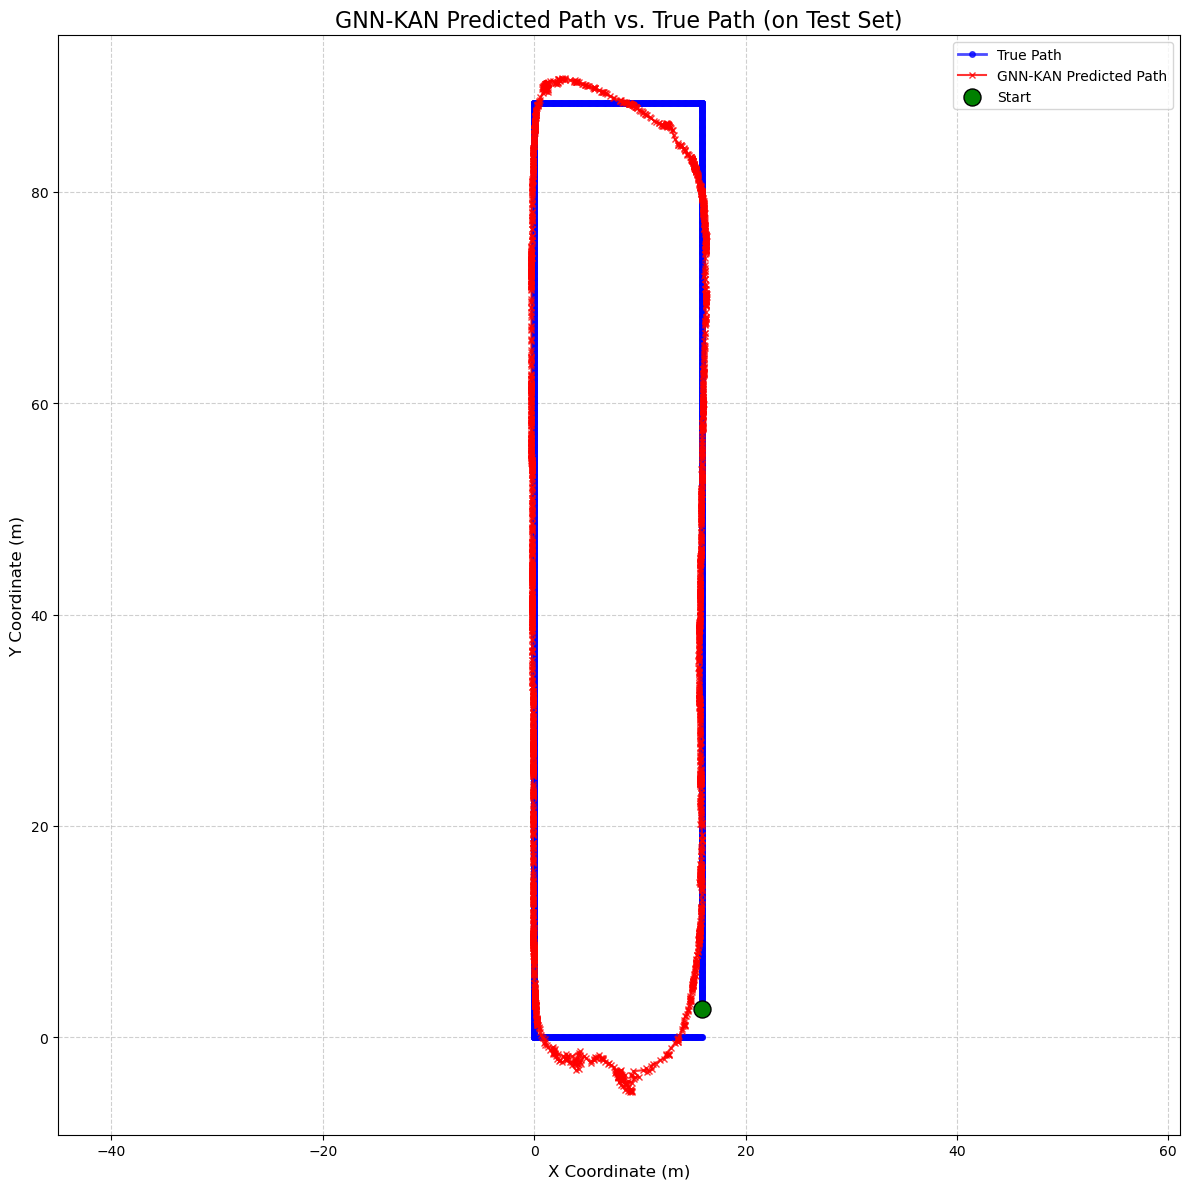

In [16]:
# =================================================================
#                         第二步: 模型和优化器定义
# =================================================================

# *** 定義 GNN-KAN 端到端模型 ***
# 維度定義
wifi_feat_dim = len(wifi_features)
imu_feat_dim = len(imu_features)
gnn_hidden_dim = 32                     # GNN 输出的融合向量维度，与 KAN 输入匹配
kan_output_dim = future_steps * 2


### 創建 GNN 實例 ###
# print("正在實例化 GNN 和 KAN 模型...")
print("正在實例化 GNN+LSTKAN 端到端模型...")
gnn_heads = 2
kan_dropout = 0.2
#实例化GNN编码器
gnn_encoder_instance = GNNEncoder(
    wifi_input_dim=wifi_feat_dim,
    imu_input_dim=imu_feat_dim,
    hidden_dim=gnn_hidden_dim, # 注意这里的 hidden_dim 是 GATv2 内部的，输出维度也是它
    windows_size=windows_size,
    num_layers=1,
    heads=gnn_heads,# 多头注意力的头数
    dropout=kan_dropout
).to(device)

kan_layers_config = [
    gnn_hidden_dim,  # 输入: 64
    64,
    # 32,             # 隐藏层1
    kan_output_dim   # 输出: 6 = future_steps × 2
]

# 2. 直接用 KAN 类构建模型
kan_predictor_instance = KAN(
    layers_hidden=kan_layers_config,
    use_lstm=True,
    lstm_hidden=32,
    dropout_rate=kan_dropout,
    grid_size=5,
    spline_order=3,
).to(device)

# 实例化最终的端到端整合模型
# end_to_end_model = GNN_plus_LSTKAN(
end_to_end_model = GNN_LSTKAN_with_Attention_v2(
    gnn_encoder=gnn_encoder_instance,
    kan_predictor=kan_predictor_instance,
    future_steps=future_steps
).to(device)

print("端到端模型实例化完成")


# 实例化损失函数
criterion = nn.HuberLoss()  
# criterion = nn.MSELoss()

INITIAL_LR = 3e-4

optimizer = optim.AdamW(end_to_end_model.parameters(), lr=INITIAL_LR, weight_decay=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=7)
num_epochs = 500
print(f"优化器与ReduceLROnPlateau调度器定义完毕，初始最大学习率: {INITIAL_LR}")
# =================================================================
#                         第三步: 训练和评估循环
# =================================================================

# 用于存储损失值
train_losses = []
val_losses = []
patience = 30                                                         # 如果验证损失在 15 个 epoch 内没有改进，则停止训练
best_val_loss = float('inf')                                          # 记录最佳验证损失
patience_counter = 0                                                  # 用于记录验证损失未改进的 epoch 数

ANNEALING_EPOCHS = 50           # 在 50 個 epoch 內，輔助損失的權重從 0 平滑增長到目標值
MAIN_LOSS_WEIGHT = 1.0          # 主要位置損失的權重
# WARMUP_EPOCHS = 10            # 预热进行的 epoch 数量，对于复杂模型，5-10个epoch是常见选择
# WARMUP_START_LR = 1e-6        # 预热开始时的学习率
KAN_REG_WEIGHT = 2e-4               # KAN正则化损失的权重
# SMOOTHNESS = 0.1
# CONSISTENCY = 0.5
# MODALITY = 0.2
# 我們需要平衡 3 個核心損失：位置、航向、平滑性
loss_weighter = LearnableLossWeighter(num_losses=2).to(device)


print(f"\n--- 開始模型訓練 (帶航向變化損失) ---")
print(f"當前損失權重: {MAIN_LOSS_WEIGHT}")





# 创建总进度条
epoch_progress = tqdm(range(num_epochs), desc="Total Epochs", unit="epoch")
for epoch in range(num_epochs):
    # --- 訓練階段 ---
    end_to_end_model.train()
    epoch_train_loss = 0

    annealing_factor = min(1.0, epoch/ANNEALING_EPOCHS)
    epoch_progress.set_description(f"Epoch {epoch+1}/{num_epochs} [Anneal Factor: {annealing_factor:.2f}]")

    # 训练阶段
    for batch in train_loader:   # 1. DataLoader 现在只返回一个批处理好的 batch 对象
        optimizer.zero_grad()         
         # 将整个 batch 对象移动到设备
        batch = batch.to(device)
        # 从 batch 对象中提取标签
        # outputs_flat = end_to_end_model(batch)

        # pred_seq = outputs_flat.view(batch.num_graphs, future_steps, 2)
        # true_seq = batch.y.view(batch.num_graphs, future_steps, 2)

         # --- 計算所有損失項 ---
        # main_loss = criterion(pred_seq, true_seq)
        # reg_loss = end_to_end_model.regularization_loss()
        # # weighted_loss = loss_weighter(head_loss)
        # total_loss = KAN_REG_WEIGHT * reg_loss + main_loss
        # total_loss.backward()
        # torch.nn.utils.clip_grad_norm_(end_to_end_model.parameters(), 1.0) # 梯度裁剪
        
        #===========================================================================
        # 【核心修改】模型現在返回 3 個輸出
        main_pred, wifi_pred, imu_pred = end_to_end_model(batch)

        true_seq = batch.y.view(batch.num_graphs, future_steps, 2)
        # jerk_loss = jerk_smoothness_loss_v2(main_pred)
        head_loss = velocity_heading_consistency_loss_v2(main_pred)
        
        # --- 計算所有損失項 ---
        # a. 主要位置損失
        main_loss = criterion(main_pred, true_seq)
        reg_loss = end_to_end_model.regularization_loss()

        total_loss =  main_loss + KAN_REG_WEIGHT*reg_loss + 1e-4*head_loss
        # total_loss = main_loss
        total_loss.backward()
        #=============================================================================
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(end_to_end_model.parameters(), 1.0)
        epoch_train_loss += total_loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    
    # 验证阶段
    end_to_end_model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            # 移动到设备
            batch = batch.to(device)

            # outputs_flat = end_to_end_model(batch)
            pred_seq,_,_ = end_to_end_model(batch)
            # pred_seq = outputs_flat.view(batch.num_graphs, future_steps, 2)

            true_seq = batch.y.view(batch.num_graphs, future_steps, 2)

            val_loss = criterion(pred_seq, true_seq)
    
            epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # ### 在驗證後更新學習率排程器 ###
        scheduler.step(avg_val_loss)

    # --- 早停與模型保存 ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # 在早停逻辑中
        torch.save(end_to_end_model.state_dict(), 'Model/end_to_end_best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
    # 强制刷新
    epoch_progress.update(1)  # 强制计数器+1，进度条会从0→1→2..
    # 每次epoch结束后，强制更新进度条的后缀信息（包含当前损失、耐心值等）
    epoch_progress.set_postfix(
        TrainLoss=f'{avg_train_loss:.4f}',
        ValLoss=f'{avg_val_loss:.4f}',
        BestVal=f'{best_val_loss:.4f}',
        Patience=f'{patience_counter}/{patience}',
        LR=f'{optimizer.param_groups[0]["lr"]:.6f}',  # 显示学习率,
        refresh=True  # 强制刷新进度条（部分环境需显式指定）
    )

    # 早停机制
    if patience_counter >= patience:
        epoch_progress.write(f"Early stopping at epoch {epoch + 1}")
        break
        
# 确保循环结束后关闭进度条
epoch_progress.close()
# ### 關鍵修正：分別加載兩個模型的最佳狀態 ###
end_to_end_model.load_state_dict(torch.load('Model/end_to_end_best_model.pth'))

# =================================================================
#                         第四步: 测试
# =================================================================
print("\nLoading best model for testing...")

# --- 将模型设置为评估模式 ---
# gnn_model.eval()
# kan_model.eval()
end_to_end_model.eval()
test_loss = 0
pred_coords_list = []
true_coords_list = []


with torch.no_grad():
     for batch in tqdm(test_loader, desc="Testing"):
        batch = batch.to(device)
        # GNN 提取單一的融合特徵向量
        # fused_embedding = gnn_model(batch) # 輸出形狀: [B, gnn_hidden_dim]
        # KAN 直接接收該向量並預測
        # outputs_flat = kan_model(fused_embedding) # 輸出形狀: [B, S*2]
        pred_seq,_,_ = end_to_end_model(batch)
        true_seq = batch.y.view(batch.num_graphs, future_steps, 2)
         
        loss = criterion(pred_seq, true_seq)

        test_loss += loss.item()

        # ### 關鍵修正 4：將輸出還原為序列形狀以進行評估 ###
        
        # 提取最後一步的預測和真實座標
        pred_last_step = pred_seq[:, -1, :].cpu().numpy()
        true_last_step = true_seq[:, -1, :].cpu().numpy()
        
        pred_coords_list.append(pred_last_step)
        true_coords_list.append(true_last_step)

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}')

# 计算MSE
pred_coords = np.concatenate(pred_coords_list, axis=0)
true_coords = np.concatenate(true_coords_list, axis=0)

# --- [核心修改] 反标准化以适应独立的X, Y缩放器 ---
pred_coords_orig = scaler.inverse_transform(pred_coords)
# 对真实坐标也做同样的操作
true_coords_orig = scaler.inverse_transform(true_coords)
# --- [修改结束] ---

result_test_df = pd.DataFrame({
    'Pred_X': [coord[0] for coord in pred_coords_orig],
    'Pred_Y': [coord[1] for coord in pred_coords_orig],
    'True_X': [coord[0] for coord in true_coords_orig],
    'True_Y': [coord[1] for coord in true_coords_orig],
})

# 保存 DataFrame 为 CSV 文件
result_test_df.to_csv(f'results/Gkan_{filesname}', index=False)
print(f"Test results saved to 'results/Gkan_{filesname}'")

# 计算评估指标
mse_x = np.mean((true_coords_orig[:, 0] - pred_coords_orig[:, 0])** 2)
mse_y = np.mean((true_coords_orig[:, 1] - pred_coords_orig[:, 1])** 2)
mse_total = np.mean((true_coords_orig - pred_coords_orig)** 2)
# --- [新增] 计算更直观的指标 ---

# 1. 计算RMSE (单位：米)
rmse_total = np.sqrt(mse_total)

# 2. 计算ADE/FDE (单位：米)
euclidean_distances = np.sqrt(np.sum((true_coords_orig - pred_coords_orig)**2, axis=1))
ade = np.mean(euclidean_distances)    
# --- 打印所有评估结果 ---
print("\n--- 模型评估结果 ---")
print(f"X轴均方误差 (MSE X): {mse_x:.4f} (米^2)")
print(f"Y轴均方误差 (MSE Y): {mse_y:.4f} (米^2)")
print(f"总均方误差 (Total MSE): {mse_total:.4f} (米^2)")
print("-" * 20)
print(f"总均方根误差 (RMSE): {rmse_total:.4f} (米)")
print(f"平均位移误差 (ADE/FDE): {ade:.4f} (米)")
print("--------------------")

    
# 可视化结果
plt.figure(figsize=(12, 5))
    
plt.subplot(1, 2, 1)
plt.scatter(true_coords_orig[:, 0], pred_coords_orig[:, 0], alpha=0.5)
plt.plot([true_coords_orig[:, 0].min(), true_coords_orig[:, 0].max()], 
             [true_coords_orig[:, 0].min(), true_coords_orig[:, 0].max()], 'r--')
plt.xlabel('True X')
plt.ylabel('Pred X')
plt.title(f'X Axis Prediction (MSE: {mse_x:.4f})')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(true_coords_orig[:, 1], pred_coords_orig[:, 1], alpha=0.5)
plt.plot([true_coords_orig[:, 1].min(), true_coords_orig[:, 1].max()], 
             [true_coords_orig[:, 1].min(), true_coords_orig[:, 1].max()], 'r--')
plt.xlabel('True Y')
plt.ylabel('Pred Y')
plt.title(f'Y Axis Prediction (MSE: {mse_y:.4f})')
plt.grid(True)
    
plt.tight_layout()
plt.savefig('Picture/prediction_results.png')
plt.show()

# =============================================================================
# ========================= 核心改动：全新的可视化模块 =========================
# =============================================================================

print("\n--- Generating visualization plots... ---")

# --- Plot 1: Training & Validation Loss Curve ---
print("Plotting training and validation loss curve...")
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='deepskyblue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='coral', linewidth=2)
best_val_epoch = np.argmin(val_losses) if val_losses else 0
best_val_score = val_losses[best_val_epoch] if val_losses else float('inf')
plt.scatter(best_val_epoch, best_val_score, marker='*', color='red', s=150, zorder=5, 
            label=f'Best Val Loss: {best_val_score:.4f} at Epoch {best_val_epoch+1}')

plt.title('Model Loss During Training', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('Picture/loss_curve_gnn_kan_en.png', dpi=300)
print("✅ Loss curve plot saved as 'Picture/loss_curve_gnn_kan_en.png'")
plt.show()


# --- Plot 2: Predicted Path vs. True Path ---
print("Plotting predicted vs. true path...")
plt.figure(figsize=(12, 12))

# Plot True Path (Blue with circles)
plt.plot(true_coords_orig[:, 0], true_coords_orig[:, 1], 'o-', label='True Path', 
         color='blue', linewidth=2, markersize=4, alpha=0.7)

# Plot Predicted Path (Red with 'x' markers)
plt.plot(pred_coords_orig[:, 0], pred_coords_orig[:, 1], 'x-', label='GNN-KAN Predicted Path', 
         color='red', linewidth=1.5, markersize=4, alpha=0.8)

# Plot Start Point
if len(true_coords_orig) > 0:
    plt.scatter(true_coords_orig[0, 0], true_coords_orig[0, 1], s=150, c='green', marker='o', edgecolors='black', label='Start', zorder=5)

# Beautify the plot
plt.title('GNN-KAN Predicted Path vs. True Path (on Test Set)', fontsize=16)
plt.xlabel('X Coordinate (m)', fontsize=12)   
plt.ylabel('Y Coordinate (m)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Ensure X and Y axes have the same scale
plt.tight_layout()
plt.savefig('Picture/path_comparison_gnn_kan_en.png', dpi=300)
print("✅ Path comparison plot saved as 'Picture/path_comparison_gnn_kan_en.png'")
plt.show()